# 0. Project Set Up

In [3]:
# Import Python packages
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import json
import sys
import cachetools
from datetime import timedelta
import math

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col, to_date

# For display purposes, suppress FutureWarnings and UserWarnings from printing below the cells
import warnings
for warning_category in [FutureWarning, UserWarning]:
    warnings.filterwarnings('ignore', category=warning_category)

### 스노우 플레이크 연결 

In [5]:
from snowflake.snowpark.context import get_active_session 
from getpass import getpass

connection_parameters = {
    'account' : "mapbobj-vp47779",
    'user' : 'soojin',
    "password": 'Kimbusan51480501@',

    
    'warehouse' : 'HACKATHON',
    'database' : 'RAW_DATA',
    'schema': 'GRANDATA'
}

# 세션 수동 생성
session = Session.builder.configs(connection_parameters).create()

# 쿼리 태그 설정 (추적용)
session.query_tag = {
    'origin': 'digital_nomad_project', # 프로젝트 명
    'name' : 'remote_work_trend_analysis', # 작업 목적
    'version' : {'major' : 1, 'minor' : 0},
    'attributes' : {
        'source' : 'jupyter',
        'analyst' : 'soojin kim '
    }
}

# print the current role, warehouse, and db/schema
print(f"role: {session.get_current_role()} | WH: {session.get_current_warehouse()} | DB.SCHEMA: {session.get_fully_qualified_current_schema()}")

role: "ACCOUNTADMIN" | WH: "HACKATHON" | DB.SCHEMA: "RAW_DATA"."GRANDATA"


In [6]:
# 재연결
from snowflake.snowpark import Session

connection_parameters = {
    "account": "mapbobj-vp47779",
    "user": "soojin",
    "password" : "Kimbusan51480501@",
    "warehouse": "HACKATHON",
    "database": "RAW_DATA",
    "schema": "GRANDATA",
    "authenticator": "snowflake"  # 브라우저 인증 방식
}

# 세션 재연결
session = Session.builder.configs(connection_parameters).create()



# 1. 데이터 확보 & 스키마 이해

In [8]:
# 테이블 로딩 
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST") # GEO 정보는 Panda로 export 후 geopandas로 처리 가능


# 일단 데이터 확인 
# Snowpark DataFrame → Pandas DataFrame
card_df_pd = card_df.to_pandas()
float_df_pd = float_df.to_pandas()
asset_df_pd = asset_df.to_pandas()
admin_df_pd = admin_df.to_pandas()


# 스키마(컬럼명, 데이터타입) 출력
print("📌 CARD_SALES_INFO schema:")
card_df.print_schema()
print("Total rows:", card_df.count())

print("\n📌 FLOATING_POPULATION_INFO schema:")
float_df.print_schema()
print("Total rows:", float_df.count())

print("\n📌 ASSET_INCOME_INFO schema:")
asset_df.print_schema()
print("Total rows:", asset_df.count())

print("\n📌 M_SCCO_MST schema:")
admin_df.print_schema()
print("Total rows:", admin_df.count())



📌 CARD_SALES_INFO schema:
root
 |-- "PROVINCE_CODE": StringType(2) (nullable = False)
 |-- "CITY_CODE": StringType(5) (nullable = False)
 |-- "DISTRICT_CODE": StringType(8) (nullable = False)
 |-- "STANDARD_YEAR_MONTH": StringType(6) (nullable = False)
 |-- "CARD_TYPE": StringType(1) (nullable = False)
 |-- "WEEKDAY_WEEKEND": StringType(1) (nullable = False)
 |-- "GENDER": StringType(1) (nullable = False)
 |-- "AGE_GROUP": StringType(2) (nullable = False)
 |-- "TIME_SLOT": StringType(3) (nullable = False)
 |-- "LIFESTYLE": StringType(3) (nullable = False)
 |-- "TOTAL_SALES": LongType() (nullable = True)
 |-- "FOOD_SALES": LongType() (nullable = True)
 |-- "COFFEE_SALES": LongType() (nullable = True)
 |-- "ENTERTAINMENT_SALES": LongType() (nullable = True)
 |-- "DEPARTMENT_STORE_SALES": LongType() (nullable = True)
 |-- "LARGE_DISCOUNT_STORE_SALES": LongType() (nullable = True)
 |-- "SMALL_RETAIL_STORE_SALES": LongType() (nullable = True)
 |-- "CLOTHING_ACCESSORIES_SALES": LongType() (n

In [9]:
# 일부 데이터 가져오기
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# 출력
print("\n💳 CARD_SALES_INFO sample:")
print(card_sample)

print("\n👥 FLOATING_POPULATION_INFO sample:")
print(float_sample)

print("\n💰 ASSET_INCOME_INFO sample:")
print(asset_sample)

print("\n🗺️ M_SCCO_MST sample:")
print(admin_sample)



💳 CARD_SALES_INFO sample:
  PROVINCE_CODE CITY_CODE DISTRICT_CODE STANDARD_YEAR_MONTH CARD_TYPE  \
0            11     11140      11140129              202112         1   
1            11     11140      11140129              202112         1   
2            11     11140      11140129              202112         1   
3            11     11140      11140129              202112         1   
4            11     11140      11140129              202112         1   

  WEEKDAY_WEEKEND GENDER AGE_GROUP TIME_SLOT LIFESTYLE  ...  TRAVEL_COUNT  \
0               H      M        30       T15       L01  ...           0.0   
1               W      F        55       T21       L01  ...           0.0   
2               W      M        40       T12       L02  ...           0.0   
3               W      M        60       T15       L04  ...           0.0   
4               W      F        50       T12       L01  ...           0.0   

   BEAUTY_COUNT  HOME_LIFE_SERVICE_COUNT  EDUCATION_ACADEMY_COUNT  \
0 

In [10]:
print(card_df_pd.describe())

        TOTAL_SALES    FOOD_SALES  COFFEE_SALES  ENTERTAINMENT_SALES  \
count  3.742994e+06  3.742994e+06  3.742994e+06         3.742994e+06   
mean   1.493614e+08  3.979121e+06  1.041453e+06         8.040715e+04   
std    1.905431e+09  5.809149e+07  2.400028e+07         1.817873e+06   
min    5.000000e+00  0.000000e+00  0.000000e+00         0.000000e+00   
25%    2.489410e+05  0.000000e+00  0.000000e+00         0.000000e+00   
50%    1.440312e+06  1.949780e+05  0.000000e+00         0.000000e+00   
75%    1.001267e+07  1.211793e+06  9.836500e+04         0.000000e+00   
max    6.528298e+11  1.488637e+10  7.385426e+09         5.892177e+08   

       DEPARTMENT_STORE_SALES  LARGE_DISCOUNT_STORE_SALES  \
count            3.742994e+06                3.742994e+06   
mean             4.105360e+06                1.811221e+06   
std              5.553114e+07                2.585855e+07   
min              0.000000e+00                0.000000e+00   
25%              0.000000e+00                0

In [11]:
# 시간대 매핑 딕셔너리 (CODE_ID == 'M03')
time_slot_map = {
    'T06': '아침',
    'T09': '오전',
    'T12': '점심',
    'T15': '오후',
    'T18': '저녁',
    'T21': '심야',
    'T24': '기타'
}

# 라이프스타일 매핑 딕셔너리 (CODE_ID == 'M06')
lifestyle_map = {
    'L01': '싱글',
    'L02': '신혼부부',
    'L03': '영유아가족',
    'L04': '청소년가족',
    'L05': '성인자녀가족',
    'L06': '실버'
}

card_df = card_df.to_pandas()

# 딕셔너리를 이용한 값 치환
card_df['TIME_SLOT'] = card_df['TIME_SLOT'].replace(time_slot_map)
card_df['LIFESTYLE'] = card_df['LIFESTYLE'].replace(lifestyle_map)

from IPython.display import display
display(card_df.head())



,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,...,TRAVEL_COUNT,BEAUTY_COUNT,HOME_LIFE_SERVICE_COUNT,EDUCATION_ACADEMY_COUNT,MEDICAL_COUNT,ELECTRONICS_FURNITURE_COUNT,CAR_SALES_COUNT,CAR_SERVICE_SUPPLIES_COUNT,GAS_STATION_COUNT,E_COMMERCE_COUNT
0,11,11140,11140126,202205,1,W,M,35,기타,영유아가족,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,11,11140,11140126,202205,1,W,F,50,심야,성인자녀가족,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,11,11140,11140126,202205,1,W,M,35,기타,싱글,...,0.0,0.0,5.21,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,11,11140,11140126,202205,1,W,M,30,저녁,*,...,0.0,0.0,0.00,0.0,5.21,0.0,0.0,0.0,0.0,0.0
4,11,11140,11140126,202205,1,H,F,40,점심,영유아가족,...,0.0,0.0,0.00,0.0,5.21,0.0,0.0,0.0,0.0,0.0


In [12]:
# 1. Snowflake에서 m_scco_mst 테이블 불러오기
mst_df = session.table("M_SCCO_MST").to_pandas()

# 2. 매핑용 딕셔너리 생성
city_map = dict(zip(mst_df['CITY_CODE'], mst_df['CITY_KOR_NAME']))
district_map = dict(zip(mst_df['DISTRICT_CODE'], mst_df['DISTRICT_KOR_NAME']))

# 3. 컬럼 타입을 str로 변환 (안 하면 KeyError 날 수 있음)
card_df['CITY_CODE'] = card_df['CITY_CODE'].astype(str)
card_df['DISTRICT_CODE'] = card_df['DISTRICT_CODE'].astype(str)

# 4. 값 치환
card_df['CITY_CODE'] = card_df['CITY_CODE'].replace(city_map)
card_df['DISTRICT_CODE'] = card_df['DISTRICT_CODE'].replace(district_map)

card_df = card_df.rename(columns={
    'CITY_CODE': 'CITY_NAME',
    'DISTRICT_CODE': 'DISTRICT_NAME'
})

from IPython.display import display
display(card_df[['CITY_NAME', 'DISTRICT_NAME']].head())


,CITY_NAME,DISTRICT_NAME
0,중구,명동1가
1,중구,명동1가
2,중구,명동1가
3,중구,명동1가
4,중구,명동1가


In [13]:
# 문자열로 변환 (혹시 숫자형일 수도 있으니)
card_df['STANDARD_YEAR_MONTH'] = card_df['STANDARD_YEAR_MONTH'].astype(str)

# 연도, 월 분리
card_df['YEAR'] = card_df['STANDARD_YEAR_MONTH'].str[:4]
card_df['MONTH'] = card_df['STANDARD_YEAR_MONTH'].str[4:6]

display(card_df[['STANDARD_YEAR_MONTH', 'YEAR', 'MONTH']].head())


,STANDARD_YEAR_MONTH,YEAR,MONTH
0,202205,2022,05
1,202205,2022,05
2,202205,2022,05
3,202205,2022,05
4,202205,2022,05


In [14]:
# 기존 컬럼 제거
card_df = card_df.drop(columns=['STANDARD_YEAR_MONTH', 'PROVINCE_CODE'])

In [15]:
display(card_df.head())

,CITY_NAME,DISTRICT_NAME,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,FOOD_SALES,...,HOME_LIFE_SERVICE_COUNT,EDUCATION_ACADEMY_COUNT,MEDICAL_COUNT,ELECTRONICS_FURNITURE_COUNT,CAR_SALES_COUNT,CAR_SERVICE_SUPPLIES_COUNT,GAS_STATION_COUNT,E_COMMERCE_COUNT,YEAR,MONTH
0,중구,명동1가,1,W,M,35,기타,영유아가족,633205,0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2022,05
1,중구,명동1가,1,W,F,50,심야,성인자녀가족,4485594,1312793,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2022,05
2,중구,명동1가,1,W,M,35,기타,싱글,1605163,0,...,5.21,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2022,05
3,중구,명동1가,1,W,M,30,저녁,*,1649461,263185,...,0.00,0.0,5.21,0.0,0.0,0.0,0.0,0.0,2022,05
4,중구,명동1가,1,H,F,40,점심,영유아가족,6832222,2621068,...,0.00,0.0,5.21,0.0,0.0,0.0,0.0,0.0,2022,05


# 2. 탄소 계수 (CF) 초기 테이블 만들기 
## 2-1. 소비탄소 지표 CSV 모으기 + 한화로 변경

In [29]:
!pip install forex-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 999.3 kB/s eta 0:00:00 0:00:01


In [31]:

import pandas as pd
from pathlib import Path
from forex_python.converter import CurrencyRates



In [33]:
RAW = Path("data/SupplyChainGHGEmissionFactors_v1.3.0_NAICS_CO2e_USD2022.csv")
OUT = Path("data/carbon_factor_supplychain_krw.csv")

# 1. csv 읽기 
df = pd.read_csv(RAW)

# 2 USD 단위 & 전체 GHG 열만 선택
mask = (
    (df["Unit"].str.contains("USD", na=False)) &
    (df["GHG"].str.contains("All", na=False))
)
df = df.loc[mask, ["2017 NAICS Title", "Supply Chain Emission Factors with Margins"]]
df = df.rename(columns={
        "2017 NAICS Title": "Category",
        "Supply Chain Emission Factors with Margins": "kgCO2e_per_USD"
     })

# 3. 환율 → 1,000원 기준 (상수 입력)
USD_KRW = 1400        # <─ 오늘자 환율 숫자만 바꿔 주세요
df["kgCO2e_per_1000KRW"] = df["kgCO2e_per_USD"] / (USD_KRW / 1000)

# 4. 저장
OUT.parent.mkdir(parents=True, exist_ok=True)
df[["Category", "kgCO2e_per_1000KRW"]].to_csv(OUT, index=False)
print("✅ CSV 저장 완료 →", OUT)
    

✅ CSV 저장 완료 → data/carbon_factor_supplychain_krw.csv


In [39]:
from pathlib import Path

# RAW = Path(r"C:\Users\SSAFY\Desktop\HACKATHON_SnowflakeXStreamlit\data\SupplyChainGHGEmissionFactors_v1.3.0_NAICS_CO2e_USD2022.csv")
RAW = Path(r"/Users/soojinkim/Desktop/snowflakeXstreamlit/data/SupplyChainGHGEmissionFactors_v1.3.0_NAICS_CO2e_USD2022.csv")

print("파일 존재?", RAW.exists())   # True여야 read_csv 가능
         # Desktop 폴더가 보이나?


파일 존재? True


## 2-2. 카드사 lifestyle 코드 <-> 탄소 카테고리 매핑표 작성

In [41]:
# 파일 경로 
CSV_FACTOR = "data/carbon_factor_supplychain_krw.csv"

# ▸ Snowflake 연결 (secrets.toml 쓰면 생략)
SNOW_CFG = {
    "account": "mapbobj-vp47779",
    "user": "soojin",
    "password" : "Kimbusan51480501@",
    "role": "ACCOUNTADMIN",
    'warehouse': "HACKATHON",
    'database' : "RAW_DATA",
    'schema'   : "GRANDATA"
}

# 1. 사용처 목록 자동 추출
usage_cols = [c for c in card_df.columns if c.endswith("_SALES")]
USAGES = [u.replace("_SALES", "") for u in usage_cols]
print(USAGES)   # ['FOOD','COFFEE', ... , 'E_COMMERCE']

['TOTAL', 'FOOD', 'COFFEE', 'ENTERTAINMENT', 'DEPARTMENT_STORE', 'LARGE_DISCOUNT_STORE', 'SMALL_RETAIL_STORE', 'CLOTHING_ACCESSORIES', 'SPORTS_CULTURE_LEISURE', 'ACCOMMODATION', 'TRAVEL', 'BEAUTY', 'HOME_LIFE_SERVICE', 'EDUCATION_ACADEMY', 'MEDICAL', 'ELECTRONICS_FURNITURE', 'CAR', 'CAR_SERVICE_SUPPLIES', 'GAS_STATION', 'E_COMMERCE']


In [195]:
import pandas as pd
import re

cf = pd.read_csv(CSV_FACTOR)

# 키워드 사전
kw_dict = {
    "FOOD": ["food", "restaurant", "catering"],
    "COFFEE": ["coffee", "tea", "cafe"],
    "ENTERTAINMENT": ["entertainment", "cinema", "theater", "music"],
    "DEPARTMENT_STORE": ["department store"],
    "LARGE_DISCOUNT_STORE": ["hypermarket", "discount", "warehouse club"],
    "SMALL_RETAIL_STORE": ["convenience", "small retail"],
    "CLOTHING_ACCESSORIES": ["clothing", "apparel", "footwear", "jewelry"],
    "SPORTS_CULTURE_LEISURE": ["sport", "leisure", "culture"],
    "ACCOMMODATION": ["hotel", "accommodation", "lodging"],
    "TRAVEL": ["travel", "airline", "tour", "rail"],
    "BEAUTY": ["beauty", "cosmetics", "hair", "spa"],
    "HOME_LIFE_SERVICE": ["home service", "cleaning", "repair"],
    "EDUCATION_ACADEMY": ["education", "academy", "training"],
    "MEDICAL": ["medical", "hospital", "clinic", "pharmacy"],
    "ELECTRONICS_FURNITURE": ["electronics", "computer", "furniture", "appliance"],
    "CAR": ["car", "auto", "vehicle", "motor"],
    "CAR_SERVICE_SUPPLIES": ["car service", "auto repair", "repair"],
    "GAS_STATION": ["gas station", "fuel", "petrol"],
    "E_COMMERCE": ["e-commerce", "online", "web", "internet", "digital"]
}

# fallback 계수
DEFAULTS = {
    "CAR": 0.4,
    "E_COMMERCE": 0.14
}

# 자동 매핑
rows = []
for usage in kw_dict.keys():
    patt = re.compile("|".join(kw_dict[usage]), re.I)
    sub = cf[cf["Category"].str.lower().str.contains(patt, na=False)]
    
    if sub.empty:
        print(f"⚠ 매핑 안됨 사용처: {usage}")
        factor = DEFAULTS.get(usage, 0)
    else:
        factor = sub["kgCO2e_per_1000KRW"].mean()

    rows.append({
        "USAGE": usage,
        "KGCO2E_PER_1000KRW": round(factor, 4)
    })

# 저장
usage_factor = pd.DataFrame(rows)
usage_factor.to_csv("usage_factor_table.csv", index=False)
usage_factor

✅ 새로운 CARD_CO2E_VW 뷰가 성공적으로 생성되었습니다.


In [45]:
# 3. snowflake: 테이블/뷰 생성 
from snowflake.snowpark import Session

session = Session.builder.configs(SNOW_CFG).create()

# 🔑 데이터베이스와 스키마 명시적으로 설정
session.sql("USE DATABASE MY_DB").collect()
session.sql("USE SCHEMA MY_SCHEMA").collect()


# 3-1 테이블 업로드
session.sql("""
    CREATE OR REPLACE TABLE USAGE_FACTOR_TBL (
        USAGE STRING,
        KGCO2E_PER_1000KRW FLOAT
    )
""").collect()


session.write_pandas(usage_factor, "USAGE_FACTOR_TBL", overwrite=True)




In [46]:
all_columns = [
    'PROVINCE_CODE', 'CITY_CODE', 'DISTRICT_CODE', 'STANDARD_YEAR_MONTH',
    'CARD_TYPE', 'WEEKDAY_WEEKEND', 'GENDER', 'AGE_GROUP', 'TIME_SLOT', 'LIFESTYLE',
    'TOTAL_SALES', 'FOOD_SALES', 'COFFEE_SALES', 'ENTERTAINMENT_SALES',
    'DEPARTMENT_STORE_SALES', 'LARGE_DISCOUNT_STORE_SALES', 'SMALL_RETAIL_STORE_SALES',
    'CLOTHING_ACCESSORIES_SALES', 'SPORTS_CULTURE_LEISURE_SALES', 'ACCOMMODATION_SALES',
    'TRAVEL_SALES', 'BEAUTY_SALES', 'HOME_LIFE_SERVICE_SALES', 'EDUCATION_ACADEMY_SALES',
    'MEDICAL_SALES', 'ELECTRONICS_FURNITURE_SALES', 'CAR_SALES', 'CAR_SERVICE_SUPPLIES_SALES',
    'GAS_STATION_SALES', 'E_COMMERCE_SALES', 'TOTAL_COUNT', 'FOOD_COUNT', 'COFFEE_COUNT',
    'ENTERTAINMENT_COUNT', 'DEPARTMENT_STORE_COUNT', 'LARGE_DISCOUNT_STORE_COUNT',
    'SMALL_RETAIL_STORE_COUNT', 'CLOTHING_ACCESSORIES_COUNT', 'SPORTS_CULTURE_LEISURE_COUNT',
    'ACCOMMODATION_COUNT', 'TRAVEL_COUNT', 'BEAUTY_COUNT', 'HOME_LIFE_SERVICE_COUNT',
    'EDUCATION_ACADEMY_COUNT', 'MEDICAL_COUNT', 'ELECTRONICS_FURNITURE_COUNT',
    'CAR_SALES_COUNT', 'CAR_SERVICE_SUPPLIES_COUNT', 'GAS_STATION_COUNT', 'E_COMMERCE_COUNT'
]

# USAGES 리스트: *_SALES 중 TOTAL_SALES 제외
USAGES = [col.replace('_SALES', '') for col in all_columns if col.endswith('_SALES') and col != 'TOTAL_SALES']


In [197]:
from snowflake.snowpark.functions import col, when
from snowflake.snowpark import Session

# 1. 매핑 딕셔너리
time_slot_map = {
    'T06': '아침', 'T09': '오전', 'T12': '점심',
    'T15': '오후', 'T18': '저녁', 'T21': '심야', 'T24': '기타'
}
lifestyle_map = {
    'L01': '싱글', 'L02': '신혼부부', 'L03': '영유아가족',
    'L04': '청소년가족', 'L05': '성인자녀가족', 'L06': '실버'
}

# 2. USAGE 리스트
USAGES = [
    "FOOD", "COFFEE", "ENTERTAINMENT", "DEPARTMENT_STORE", "LARGE_DISCOUNT_STORE",
    "SMALL_RETAIL_STORE", "CLOTHING_ACCESSORIES", "SPORTS_CULTURE_LEISURE",
    "ACCOMMODATION", "TRAVEL", "BEAUTY", "HOME_LIFE_SERVICE", "EDUCATION_ACADEMY",
    "MEDICAL", "ELECTRONICS_FURNITURE", "CAR", "CAR_SERVICE_SUPPLIES",
    "GAS_STATION", "E_COMMERCE"
]
unp_cols = ", ".join([f"{usage}_SALES" for usage in USAGES])

# 3. SQL 코드 생성
create_view_sql = f"""
CREATE OR REPLACE VIEW MY_DB.MY_SCHEMA.CARD_CO2E_VW AS
WITH base AS (
  SELECT 
    *,
    REPLACE(usage, '_SALES', '') AS usage_clean,
    value AS sales_amt
  FROM MY_DB.MY_SCHEMA.CARD_SALES_INFO
  UNPIVOT(value FOR usage IN ({unp_cols}))
)
SELECT 
  b.PROVINCE_CODE,
  b.CITY_CODE,
  b.DISTRICT_CODE,
  m.CITY_KOR_NAME AS CITY_NAME,
  m.DISTRICT_KOR_NAME AS DISTRICT_NAME,
  b.STANDARD_YEAR_MONTH,
  LEFT(b.STANDARD_YEAR_MONTH, 4) AS YEAR,
  RIGHT(b.STANDARD_YEAR_MONTH, 2) AS MONTH,
  b.CARD_TYPE,
  b.WEEKDAY_WEEKEND,
  b.GENDER,
  b.AGE_GROUP,
  b.TIME_SLOT,
  b.LIFESTYLE,

  CASE b.TIME_SLOT
    {''.join([f"WHEN '{k}' THEN '{v}' " for k, v in time_slot_map.items()])}
    ELSE b.TIME_SLOT
  END AS TIME_SLOT_LABEL,

  CASE b.LIFESTYLE
    {''.join([f"WHEN '{k}' THEN '{v}' " for k, v in lifestyle_map.items()])}
    ELSE b.LIFESTYLE
  END AS LIFESTYLE_LABEL,

  b.usage_clean,
  b.sales_amt,
  f.KGCO2E_PER_1000KRW,
  (b.sales_amt / 1000) * f.KGCO2E_PER_1000KRW AS CO2E_KG

FROM base b
JOIN MY_DB.MY_SCHEMA.M_SCCO_MST m
  ON b.CITY_CODE = m.CITY_CODE AND b.DISTRICT_CODE = m.DISTRICT_CODE
LEFT JOIN MY_DB.MY_SCHEMA.USAGE_FACTOR_TBL f
  ON upper(b.usage_clean) = upper(f.USAGE)
WHERE 
  sales_amt > 0 AND
  f.KGCO2E_PER_1000KRW IS NOT NULL
"""

# 4. 실행
session.sql(create_view_sql).collect()
print("✅ 새로운 CARD_CO2E_VW 뷰가 성공적으로 생성되었습니다.")


✅ 새로운 CARD_CO2E_VW 뷰가 성공적으로 생성되었습니다.


In [199]:
session.table("MY_DB.MY_SCHEMA.CARD_CO2E_VW").limit(500).to_pandas()


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,YEAR,MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TIME_SLOT_LABEL,LIFESTYLE_LABEL,USAGE_CLEAN,SALES_AMT,KGCO2E_PER_1000KRW,CO2E_KG
0,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,M,45,T21,L04,심야,청소년가족,SMALL_RETAIL_STORE,243712,0.1321,32.194355
1,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,M,45,T15,L01,오후,싱글,COFFEE,41351,0.2018,8.344632
2,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,M,45,T15,L01,오후,싱글,SMALL_RETAIL_STORE,93040,0.1321,12.290584
3,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,H,M,50,T06,L04,아침,청소년가족,FOOD,113715,0.1907,21.685451
4,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,H,M,50,T06,L04,아침,청소년가족,SMALL_RETAIL_STORE,76499,0.1321,10.105518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,M,45,T09,L01,오전,싱글,SMALL_RETAIL_STORE,116300,0.1321,15.363230
496,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,F,35,T15,L04,오후,청소년가족,FOOD,52722,0.1907,10.054085
497,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,F,35,T15,L04,오후,청소년가족,COFFEE,29979,0.2018,6.049762
498,11,11140,11140106,중구,남대문로1가,202112,2021,12,1,W,F,35,T15,L04,오후,청소년가족,CLOTHING_ACCESSORIES,366990,0.1058,38.827542


In [201]:
# 특정 지역/연월만 필터링 
session.table("MY_DB.MY_SCHEMA.CARD_CO2E_VW") \
    .filter((F.col("CITY_NAME") == "서초구") & (F.col("STANDARD_YEAR_MONTH") == "202309")) \
    .limit(10).to_pandas()


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,YEAR,MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TIME_SLOT_LABEL,LIFESTYLE_LABEL,USAGE_CLEAN,SALES_AMT,KGCO2E_PER_1000KRW,CO2E_KG
0,11,11650,11650104,서초구,원지동,202309,2023,09,1,H,F,25,T21,L01,심야,싱글,COFFEE,29043,0.2018,5.860877
1,11,11650,11650104,서초구,원지동,202309,2023,09,1,H,F,25,T21,L01,심야,싱글,SMALL_RETAIL_STORE,833527,0.1321,110.108917
2,11,11650,11650104,서초구,원지동,202309,2023,09,1,H,F,25,T21,L01,심야,싱글,GAS_STATION,8289269,0.2973,2464.399674
3,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,55,T09,L01,오전,싱글,FOOD,1013328,0.1907,193.241650
4,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,55,T09,L01,오전,싱글,SMALL_RETAIL_STORE,195379,0.1321,25.809566
5,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,55,T09,L01,오전,싱글,GAS_STATION,1765462,0.2973,524.871853
6,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,45,T09,L01,오전,싱글,FOOD,1187585,0.1907,226.472460
7,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,45,T09,L01,오전,싱글,SMALL_RETAIL_STORE,355378,0.1321,46.945434
8,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,45,T09,L01,오전,싱글,SPORTS_CULTURE_LEISURE,264025,0.3711,97.979677
9,11,11650,11650104,서초구,원지동,202309,2023,09,1,W,F,45,T09,L01,오전,싱글,GAS_STATION,2902106,0.2973,862.796114


In [203]:
# 사용처별 co2 합계 
session.table("MY_DB.MY_SCHEMA.CARD_CO2E_VW") \
    .group_by("usage_clean") \
    .agg(F.sum("CO2E_KG").alias("total_co2e")) \
    .sort(F.col("total_co2e").desc()) \
    .limit(10).to_pandas()


,USAGE_CLEAN,TOTAL_CO2E
0,HOME_LIFE_SERVICE,7.514498e+09
1,CAR,5.581302e+09
2,E_COMMERCE,4.657356e+09
3,FOOD,2.840252e+09
4,SMALL_RETAIL_STORE,2.291772e+09
5,DEPARTMENT_STORE,1.799398e+09
6,SPORTS_CULTURE_LEISURE,1.217908e+09
7,LARGE_DISCOUNT_STORE,7.938664e+08
8,COFFEE,7.866472e+08
9,MEDICAL,7.714415e+08


In [205]:
session.table("MY_DB.MY_SCHEMA.CARD_CO2E_VW") \
    .group_by("YEAR", "MONTH") \
    .agg(F.sum("CO2E_KG").alias("monthly_co2e")) \
    .sort(["YEAR", "MONTH"]) \
    .to_pandas()


,YEAR,MONTH,MONTHLY_CO2E
0,2021,01,7.547429e+08
1,2021,02,7.199517e+08
2,2021,03,8.722272e+08
3,2021,04,8.371502e+08
4,2021,05,8.615779e+08
5,2021,06,8.631681e+08
6,2021,07,8.423209e+08
7,2021,08,7.993989e+08
8,2021,09,8.094452e+08
9,2021,10,8.505420e+08


# 3. Baseline β - 단순 계산으로 MVP
- 최초 실행 가능한 프로토타입 (Minimum Viable Product)
- "가상의 카드 사용 이력만으로도 CO2 배출량 계산하고 시각화"할 수 있는지 검증하는 MVP

### 구체적인 목표 
번호	목표	설명

3-1	카드 소비와 탄소계수 연결	CARD_SALES_INFO 와 CARBON_FACTOR_TBL 을 JOIN해서 사용처별 탄소배출량 계산

3-2	CO₂ 배출량 계산	각 사용처에서의 탄소 배출량 = 총 소비액 ÷ 1000 × 탄소계수

3-3	Streamlit에서 MVP 시각화	카드 번호(가상) 입력 → 지난 달 CO₂ 배출량 총합 & 상위 3개 사용처 출력

### 최종 확인 기준 
- 로컬 웹 페이지에서 "지난달 27kg CO2 배출"
  => 데이터 -> 분석 -> 사용자 피드백까지 A to Z 흐름 완성
  => 다음 단계 (적립, 사용자별 비교, 감축 분석 등)로 자연스럽게 확장

=> 처음으로 눈에 보이는 성과 만드는 단계 
"지난달에 너 이만큼 배출했어!" 라고 말해줄 수 있는 MVP

In [153]:
## 스트림릿 - app.py로 함

# 4. 계수 고도화 모델
### 해야하는 이유 
- 현재 탄소 배출량 계산: 카테고리 매출액 * 평균 탄소 계수
- 현실:
  - 같은 카테고리 안에서도 라이프스타일이나 계절, 도시에 따라 소비 패턴 다름
  - 동일한 1,000원이라도 어떤 소비자/상황에서 쓰이느냐에 따라 탄소 배출량 달라질 수 있음
  => 더 정밀한 Context-aware 탄소 계수 필요

### 4단계 목표

🎯 1. 계수의 세분화	Lifestyle × Category × 월 별 탄소계수로 분포를 분석해 이상치 제거 및 정규화

🧠 2. Graph 기반 예측 모델 학습	소비 패턴 관계를 그래프 구조로 모델링 (Category ↔ Lifestyle ↔ Time)

🧪 3. 고도화 모델 도입 (GraphSAGE)	PyTorch Geometric을 활용한 그래프 임베딩 기반 회귀 모델

🔁 4. Snowflake UDF 배포	predict_co2e(category, lifestyle, amount) 형태의 예측 함수로 Snowflake에서 바로 활용

🌀 5. 자동화 (옵션)	모델 업데이트를 Airflow로 자동화하여 실시간 적용 가능하도록 구성

### 완성된 후 활용
- 사용자에게 '당신의 라이프스타일 기준 예상 탄소 배출량은 1,322g이에요.'라는 정확한 피드백 제공
- 인센티브 계산, 정책 시뮬레이션 등에도 정확한 근거 제공
- 향후 추천 시스템과도 연동 가능 (ex. 탄소 덜 유발하는 대체 소비 제안)


                          Latent_1      Latent_2      Latent_3      Latent_4  \
YEAR MONTH LIFESTYLE_KOR                                                       
2021 01    *              0.685706 -3.506922e-16 -8.355036e-16  2.095705e-16   
           성인자녀가족         0.685706 -2.674254e-16 -7.799924e-16  1.818149e-16   
           신혼부부           0.685706 -2.639560e-16 -7.869313e-16  2.061010e-16   
           실버             0.685706 -2.674254e-16 -8.216258e-16  1.540593e-16   
           싱글             0.685706 -3.220114e-16 -8.108654e-16  2.087417e-16   

                              Latent_5  
YEAR MONTH LIFESTYLE_KOR                
2021 01    *             -5.169840e-16  
           성인자녀가족        -5.169840e-16  
           신혼부부          -4.892284e-16  
           실버            -5.031062e-16  
           싱글            -5.153738e-16  


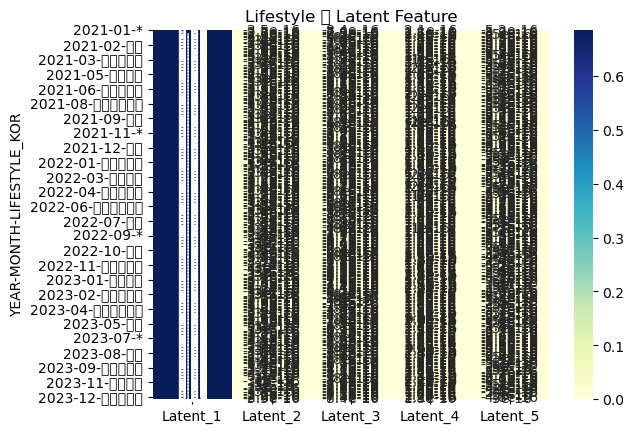

In [223]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SVD 모델 설정
n_components = 5  # 잠재요인 수는 3~10 사이에서 튜닝 가능
svd = TruncatedSVD(n_components=n_components)

# 2. 행렬 분해 수행
latent_matrix = svd.fit_transform(pivot_df)
components = svd.components_

# 3. 결과 시각화: LIFESTYLE vs 잠재 요인
lifestyle_latents = pd.DataFrame(latent_matrix, index=pivot_df.index, columns=[f"Latent_{i+1}" for i in range(n_components)])
print(lifestyle_latents.head())

# (선택) 시각화
sns.heatmap(lifestyle_latents, annot=True, cmap="YlGnBu")
plt.title("Lifestyle 별 Latent Feature")
plt.show()


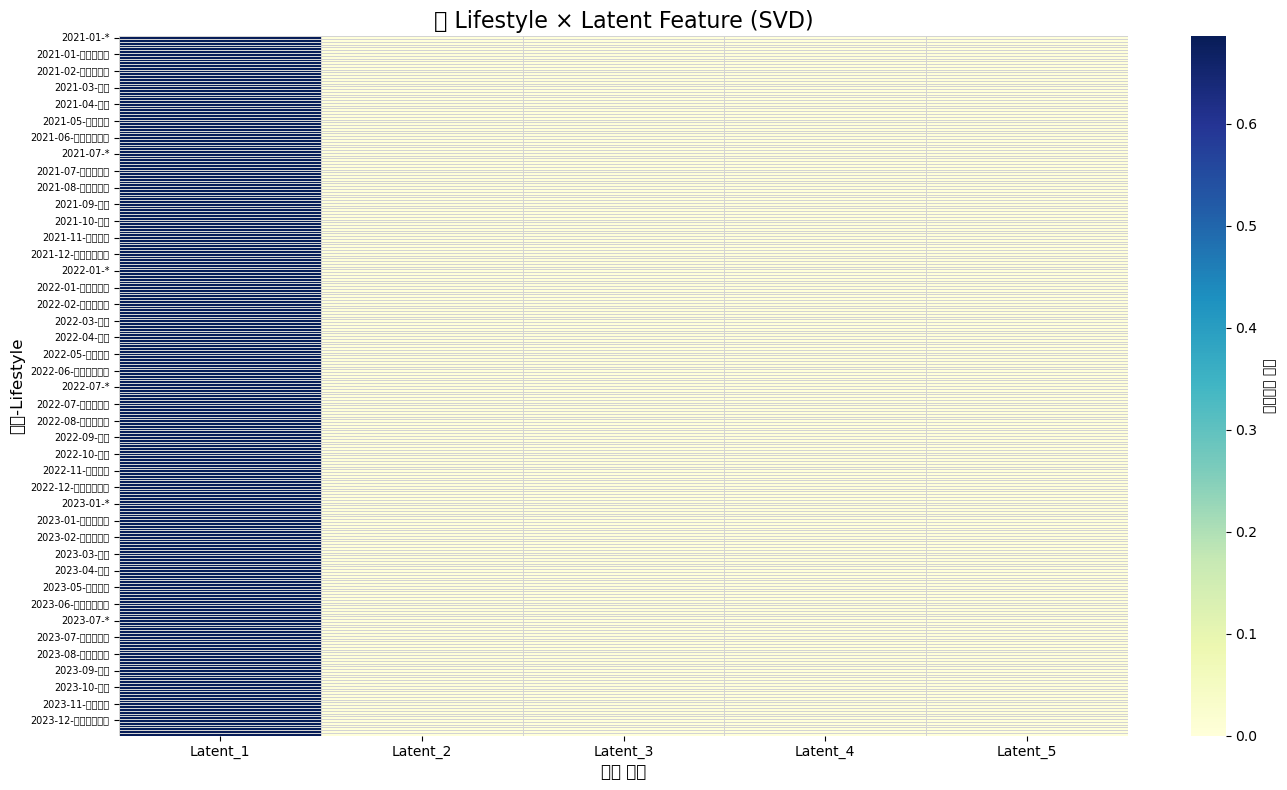

In [231]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SVD 설정
n_components = 5
svd = TruncatedSVD(n_components=n_components)

# 2. SVD 실행
latent_matrix = svd.fit_transform(pivot_df)
components = svd.components_

# 3. Index 포맷 정리 (문자열 처리!)
index_labels = [
    f"{str(y)}-{str(m).zfill(2)}-{l}" for (y, m, l) in pivot_df.index
]

# 4. DataFrame 생성
lifestyle_latents = pd.DataFrame(
    latent_matrix,
    index=index_labels,
    columns=[f"Latent_{i+1}" for i in range(n_components)]
)

# 5. Heatmap 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(
    lifestyle_latents,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='lightgrey',
    cbar_kws={"label": "잠재요인 강도"}
)
plt.title("📌 Lifestyle × Latent Feature (SVD)", fontsize=16)
plt.ylabel("기간-Lifestyle", fontsize=12)
plt.xlabel("잠재 요인", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()


- heatmap이 의미 있는 구분 없이 Latent_1만 높고 나머지는 0에 가까운 값
#### 왜 이렇게 나옴? 
1. 입력 행렬(pivot_df)에 편향이 있거나 희소(sparse)한 경우
-> 대부분의 값이 0에 가깝거나 특정 범위로 쏠려 있어서, SVD가 하나의 주요 축만 학습
2. 정규화 안된 값으로 인해 하나의 요인만 부각
-> lifestyle마다 scale 다르면 특정 요인만 압도적으로 커짐

=> 정규화 + 평균 제거 후 SVD 
- StandardScaler를 통해 lifestyle 별 값들을 표준 정규화해서 분산을 맞추고,
- SVD가 더 다양한 방향의 특성을 반영한 잠재 요인 학습할 수 있음
- Latent_1뿐만 아니라 Latent_2-5도 분산 생기고 시각화 비교도 가능 

### 📌 질문 1.
#### “근데 StandardScaler는 열(column)을 정규화하는 건데, 그걸 왜 해야 해?”
✔️ **StandardScaler는 각 column(=사용처)**를 평균 0, 표준편차 1로 정규화해.
이유는 간단해: 사용처마다 값의 scale이 다르기 때문이야.

#### 예시로 설명해볼게:
Lifestyle	FOOD	TRAVEL	E_COMMERCE
싱글	50000	3000	8000
실버	60000	3500	7000
신혼부부	65000	4000	7500
여기서 FOOD는 단위가 커서 수치가 5~6만, TRAVEL은 수천 단위지?
이걸 그냥 SVD에 넣으면 **값이 큰 열(=FOOD)**이 잠재요인 대부분을 설명해버려.

즉,

✖️ 큰 값 = 중요하다고 잘못 해석됨 → 왜곡된 latent feature 나옴.

#### ✅ 그래서 해결책이 StandardScaler
python
코드 복사
StandardScaler().fit_transform(pivot_df)
이걸 해주면:

각 사용처가 동등한 중요도로 latent factor에 반영됨

즉, 값이 큰 것만 반영되는 걸 방지하고

"사용처의 패턴 차이"만 반영하게 됨

### 📌 질문 2.
“SVD가 더 다양한 방향의 특성을 반영한 잠재요인을 학습할 수 있다는 건 무슨 말이야?”
SVD는 이렇게 생각하면 돼:

🔍 "입력 행렬을 여러 개의 축(Latent Direction)으로 분해해서,
그 축이 설명하는 **패턴(=잠재요인)**을 뽑아내는 기법"

근데 문제가 생긴다?
정규화 안 하면:

Latent_1이 전체 분산의 99%를 먹고

Latent_2~5는 거의 0에 가까운 값 (정보를 안 담음)

즉,

✖️ SVD가 "하나의 방향만" 설명하게 되면서
잠재요인의 다양성이 사라지는 현상이 생김

#### ✅ 정규화하면?
각 feature가 같은 scale에서 기여하니까

Latent_1, Latent_2, Latent_3... 가
서로 다른 특성을 나눠 담게 돼

즉,

✔️ "한 방향에 몰빵되지 않고, 여러 방향(축)에서 의미 있는 latent feature를 뽑을 수 있다."

### ✅ 요약
개념	설명
StandardScaler()	각 사용처가 동등한 중요도로 취급되도록 스케일 조정
SVD의 다양한 축	여러 잠재 요인이 서로 다른 "사용처-라이프스타일 패턴"을 반영할 수 있게 해줌


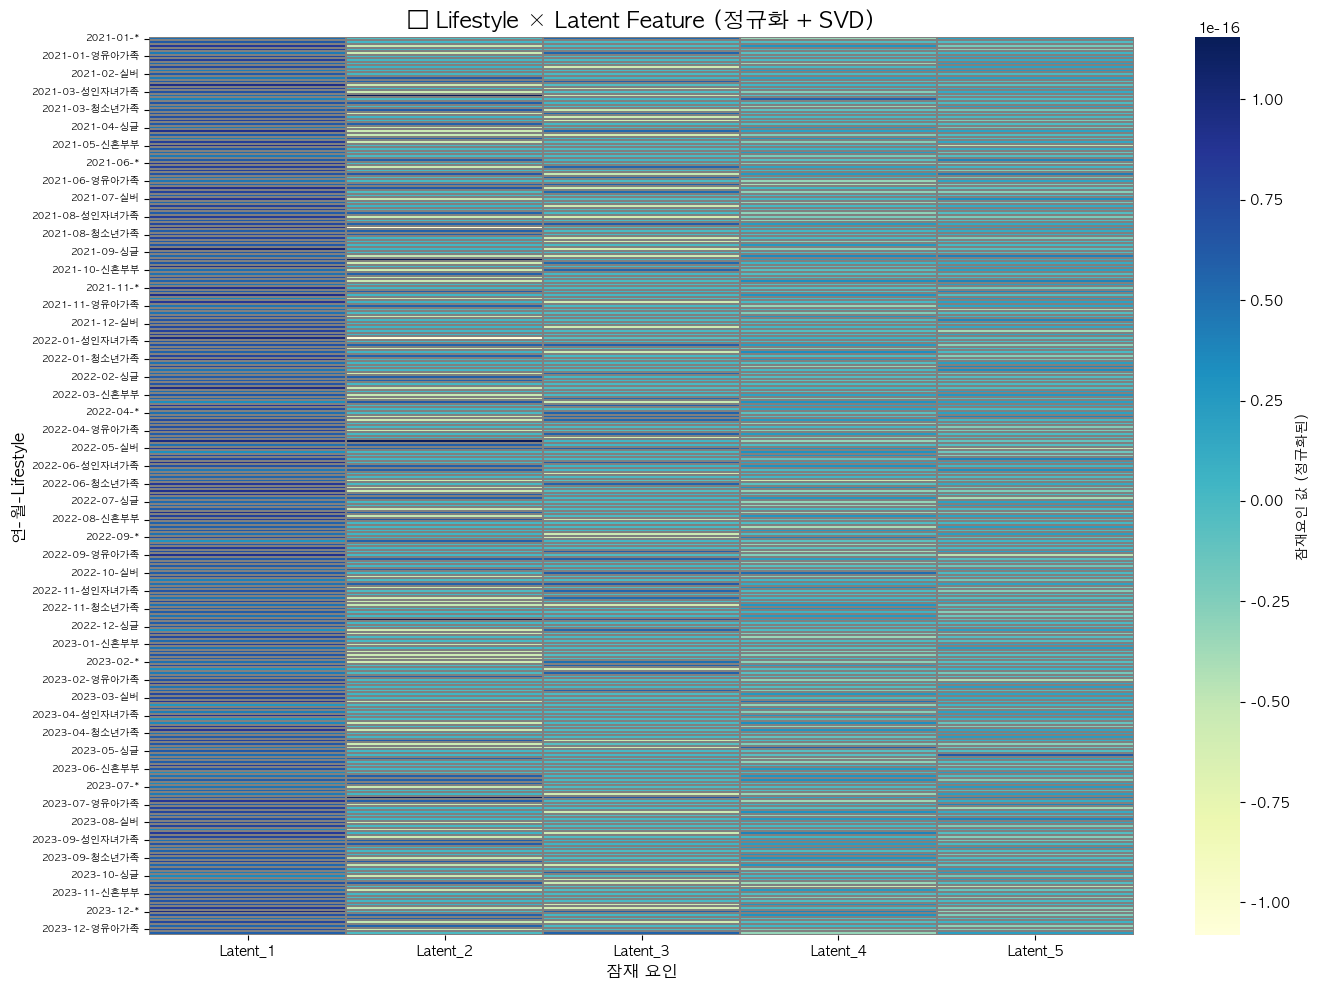

In [239]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import matplotlib

# ✅ OS에 따라 한글 폰트 설정
if platform.system() == "Windows":
    matplotlib.rc('font', family='Malgun Gothic')  # 윈도우
elif platform.system() == "Darwin":
    matplotlib.rc('font', family='AppleGothic')    # 맥
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 1. 정규화 (z-score)
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_df)

# 2. SVD 설정 및 실행
n_components = 5
svd = TruncatedSVD(n_components=n_components)
latent_matrix = svd.fit_transform(pivot_scaled)

# 3. 인덱스 정리
index_labels = [f"{str(y)}-{str(m).zfill(2)}-{l}" for (y, m, l) in pivot_df.index]

# 4. 결과 프레임 생성
lifestyle_latents = pd.DataFrame(
    latent_matrix,
    index=index_labels,
    columns=[f"Latent_{i+1}" for i in range(n_components)]
)

# 5. 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(
    lifestyle_latents,
    cmap="YlGnBu",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={"label": "잠재요인 값 (정규화된)"}
)
plt.title("📌 Lifestyle × Latent Feature (정규화 + SVD)", fontsize=16)
plt.xlabel("잠재 요인", fontsize=12)
plt.ylabel("연-월-Lifestyle", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()


### ✅ 잠재요인 (Latent Feature)란?
직접 관측할 수는 없지만, 데이터 속에 숨어 있는 숨겨진 특성값을 말해.

### 🧠 예를 들어볼게:
너가 지금 분석하고 있는 건 아래와 같은 라이프스타일 × 사용처 카테고리별 CO₂ 계수 데이터야.

라이프스타일	커피	음식	여행	의료	…

신혼부부	0.2	0.18	0.4	0.12

실버	0.21	0.19	0.35	0.13	
…					
이걸 SVD로 분해하면, 아래처럼 바뀜:

### 🎯 Matrix Factorization 결과:
왼쪽 행렬은 **라이프스타일 별 '잠재요인 벡터'**로 바뀌고

오른쪽 행렬은 **카테고리 별 '잠재요인 벡터'**로 바뀜

코드 복사
라이프스타일 = [Latent_1, Latent_2, ..., Latent_5]
즉, 각 라이프스타일이:

Latent_1: 외식 소비 경향

Latent_2: 의료 중심

Latent_3: 온라인 소비 성향

Latent_4: 차량 의존성

Latent_5: 레저/여가 지향도

와 같은 숨겨진 축 위에서 어느 쪽에 얼마나 가까운지를 표현하는 거야.

이런 Latent는 SVD가 직접 데이터의 패턴을 보고 수학적으로 "추출"해낸 특성이지, 사람이 만든 게 아님.

### 🧩 왜 필요한가?
눈에 보이지 않던 라이프스타일의 본질적인 소비 패턴을 찾을 수 있음

예: "신혼부부는 Latent_3이 강하다" → 온라인 소비 경향 강함?

이걸 바탕으로 유사 라이프스타일 추천, 트렌드 예측 등에 활용 가능해



## 🎯 GNN 분석을 통해 네가 얻을 수 있는 것
### 1️⃣ 단순 계수 기반이 아닌 구조 기반 관계 학습
지금까지는 "이 라이프스타일은 어떤 소비에서 탄소배출이 많더라"를 단순 평균으로 본 거잖아?

그런데 GNN은 이걸 그래프 구조로 보면서, "연관성이 높은 라이프스타일끼리", **"유사한 소비 사용처끼리"**를 서로 영향 주는 존재로 학습해.

즉, "라이프스타일A는 커피를 많이 마신다 → 라이프스타일B도 비슷한 구조니까 커피를 더 마실 가능성이 있음" 같은 전이 가능성까지 모델링 가능.

### 2️⃣ 의미 기반 임베딩 벡터 (Embedding) 생성
각각의 라이프스타일과 사용처를 벡터로 표현하면, 이걸 가지고

유사도 기반 추천

탄소 절감 포인트 예측

행동 변화 유도 설계

클러스터링 + 세그먼트 마케팅 등에 응용할 수 있어.

#### 예시:

##### 🧬 Lifestyle "싱글"의 벡터와 유사한 사용처는?
→ GNN으로 뽑아낸 벡터들끼리 cosine similarity로 비교 → 상관관계 있는 소비 추천 or 절감 제안

📊 특정 Lifestyle이 새로 유입되었을 때?
→ 노드 추가 + message passing → 탄소 배출 예측
### 3️⃣ 향후 추천 시스템의 핵심 기반
MF는 행렬 안의 "숫자" 관계만 봐.

GNN은 "관계 그 자체", 즉 "노드와 노드 사이의 연결 의미"를 학습해.

만약 향후 라이프스타일 ↔ 사용처 ↔ 지역 정보까지 연결하고 싶으면, MF보다 GNN이 훨씬 유리해.

### 🔥 요약
분석 방법	주요 특성	활용 예시
MF	단순 숫자 기반, 빠름	빠른 추천, 인사이트 도출
GNN	관계 기반, 유연함	의미 기반 추천, 구조적 이해, 예측
즉, MF는 마케팅용, GNN은 전략 + 추천용이라고 보면 돼.
너처럼 구조적 인사이트 + 행동 유도까지 보고자 한다면, GNN은 꽤 값진 도구가 될 거야.



#### 4-2-1. Matrix Factorization (MF)
- 행: LIFESTYLE (유저 역할)
- 열: USAGE_CLEAN (아이템 역할)
- 값: AVG_KGCO2_PER_1000KWR (평점 역할)

##### 목표: LIFESTYLE * USAGE_CLEAN -> co2 배출량 평균값 기반으로 비어있는 조합 (사용처) 예측해서 탄소절감 추천에 사용

### 4-2-2. GNN (Graph Neural Network)
- 노드: 라이프 스타일, 사용처 각각을 노드로 간주
- 엣지: LIFESTYLE -> USAGE_CLEAN, 엣지 weight는 AVG_KGCO2_PER_1000KRW

In [125]:
# 1. 엣지 리스트 형식으로 변환
edge_df = eda_df[["LIFESTYLE_KOR", "USAGE_CLEAN", "AVG_KGCO2_PER_1000KRW"]]
edge_df.columns = ["source", "target", "weight"]

# 2. 저장 or GNN 라이브러리에서 활용 가능
edge_df.to_csv("carbon_graph_edges.csv", index=False)
